<a href="https://colab.research.google.com/github/dhanush852/intro_to_deeplearning/blob/main/Homework2q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score,
    confusion_matrix, classification_report, f1_score
)



In [2]:
torch.set_printoptions(edgeitems=2)
np.random.seed(123)
torch.manual_seed(123)

In [3]:
# Choose the device based on availability of CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [4]:
# Load CIFAR10 training dataset with DataLoader
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

# Function to compute mean and std
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5
    return mean, std

# Calculate mean and std
mean, std = get_mean_std(train_loader)
print("Mean:", mean)
print("Std:", std)

100%|██████████| 170498071/170498071 [00:04<00:00, 41470283.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean: tensor([0.4915, 0.4822, 0.4466])
Std: tensor([0.2470, 0.2435, 0.2616])


In [5]:
# Define transformation for CIFAR10 dataset
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load CIFAR10 training dataset
cifar10 = datasets.CIFAR10('./data', train=True, download=False, transform=cifar_transform)


In [6]:
# Assuming the cifar_transform is already defined as shown in the previous optimization
# Load CIFAR10 validation dataset
cifar10_val = datasets.CIFAR10('./data', train=False, download=False, transform=cifar_transform)


In [7]:
# Print the shape of the first image in the CIFAR10 dataset
print(cifar10[0][0].shape)


torch.Size([3, 32, 32])


In [8]:
# DataLoader parameters
batch_size = 32
num_workers = 2

# Create DataLoaders for training and testing
train_loader = DataLoader(cifar10, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(cifar10_val, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [9]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.0):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_rate=dropout_rate)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout_rate))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18(dropout_rate=0.0):
    return ResNet(BasicBlock, [2, 2, 2, 2], dropout_rate=dropout_rate)




In [11]:
# Initialize the neural network model, setting it to use GPU if available
neural_net = ResNet18(dropout_rate=0.0).to(device)  # 4 blocks with 1 layer each

loss_function = nn.CrossEntropyLoss()
sgd_optimizer = torch.optim.SGD(neural_net.parameters(), lr=0.01)


In [12]:
# Initialize metrics storage
train_losses, val_losses, accuracies = [], [], []

# Conduct a single epoch of training and validation
for epoch in range(25):
    neural_net.train()  # Prepare model for training phase
    total_train_loss = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        sgd_optimizer.zero_grad()
        output = neural_net(inputs)
        loss = loss_function(output, labels)
        loss.backward()
        sgd_optimizer.step()
        total_train_loss += loss.item()

    # Calculate and store average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Switch to evaluation mode for validation phase
    neural_net.eval()
    total_val_loss, correct_predictions, total_samples = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = neural_net(images)
            loss = loss_function(output, labels)
            total_val_loss += loss.item()
            predictions = output.argmax(dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate and store average validation loss and accuracy
    avg_val_loss = total_val_loss / len(test_loader)
    accuracy = correct_predictions / total_samples * 100
    val_losses.append(avg_val_loss)
    accuracies.append(accuracy)

    # Print metrics for the current epoch
    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')



Epoch 1, Training Loss: 1.2880, Validation Loss: 1.5339, Validation Accuracy: 52.61%
Epoch 2, Training Loss: 0.7800, Validation Loss: 0.9431, Validation Accuracy: 67.60%
Epoch 3, Training Loss: 0.5505, Validation Loss: 0.7128, Validation Accuracy: 75.32%
Epoch 4, Training Loss: 0.3914, Validation Loss: 0.6702, Validation Accuracy: 77.49%
Epoch 5, Training Loss: 0.2598, Validation Loss: 0.9887, Validation Accuracy: 73.07%
Epoch 6, Training Loss: 0.1668, Validation Loss: 0.9441, Validation Accuracy: 74.71%
Epoch 7, Training Loss: 0.1070, Validation Loss: 0.8151, Validation Accuracy: 78.37%
Epoch 8, Training Loss: 0.0740, Validation Loss: 1.1715, Validation Accuracy: 73.78%
Epoch 9, Training Loss: 0.0516, Validation Loss: 0.7869, Validation Accuracy: 80.59%
Epoch 10, Training Loss: 0.0422, Validation Loss: 0.9787, Validation Accuracy: 77.79%
Epoch 11, Training Loss: 0.0311, Validation Loss: 1.2537, Validation Accuracy: 75.62%
Epoch 12, Training Loss: 0.0262, Validation Loss: 0.9033, Valid

In [15]:
neural_net.eval()
all_predictions, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = neural_net(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

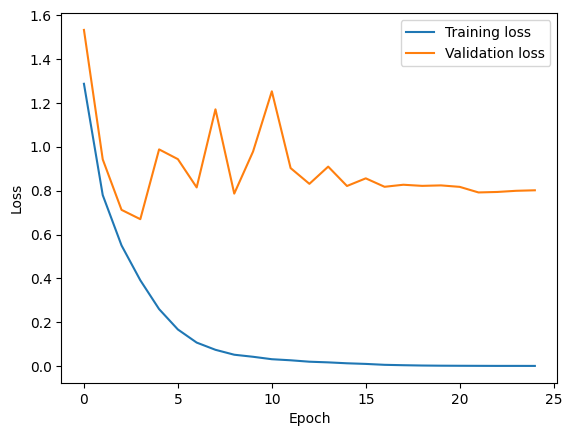

In [16]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


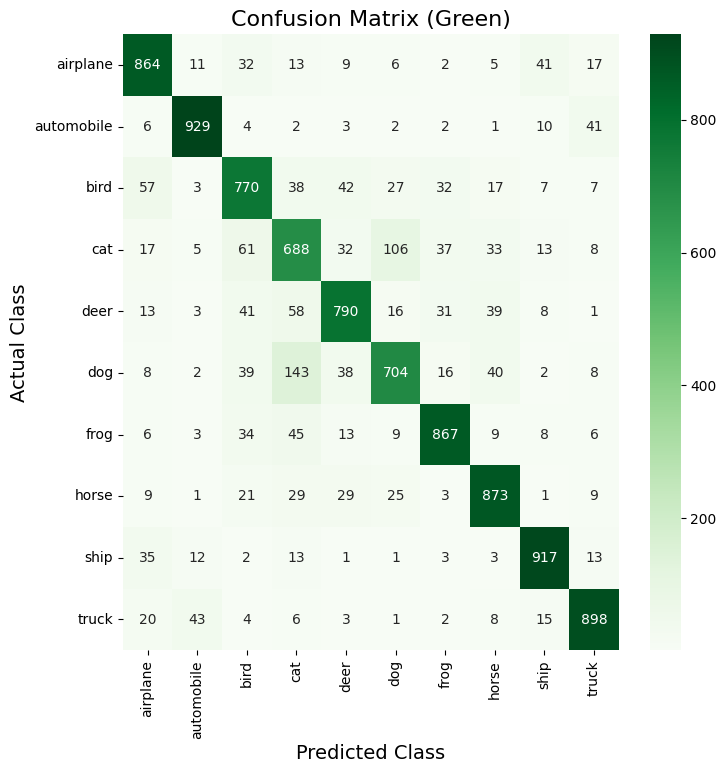

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Define the colormap as green
cmap = sns.color_palette("Greens", as_cmap=True)

# Create the heatmap with the specified colormap
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap=cmap, fmt="d", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("Actual Class", fontsize=14)
plt.title("Confusion Matrix (Green)", fontsize=16)
plt.show()

In [28]:
# Initialize the neural network model, setting it to use GPU if available
neural_net = ResNet18(dropout_rate=0.25).to(device)  # 4 blocks with 1 layer each

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(neural_net.parameters(), lr=0.001)


In [29]:
# Initialize metrics storage
train_losses, val_losses, accuracies = [], [], []

# Conduct a single epoch of training and validation
for epoch in range(10):
    neural_net.train()  # Prepare model for training phase
    total_train_loss = 0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = neural_net(inputs)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Calculate and store average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Switch to evaluation mode for validation phase
    neural_net.eval()
    total_val_loss, correct_predictions, total_samples = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = neural_net(images)
            loss = loss_function(output, labels)
            total_val_loss += loss.item()
            predictions = output.argmax(dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate and store average validation loss and accuracy
    avg_val_loss = total_val_loss / len(test_loader)
    accuracy = correct_predictions / total_samples * 100
    val_losses.append(avg_val_loss)
    accuracies.append(accuracy)

    # Print metrics for the current epoch
    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')



Epoch 1, Training Loss: 1.9185, Validation Loss: 2.1870, Validation Accuracy: 23.78%
Epoch 2, Training Loss: 1.5819, Validation Loss: 1.7068, Validation Accuracy: 39.55%
Epoch 3, Training Loss: 1.4318, Validation Loss: 1.5283, Validation Accuracy: 46.13%
Epoch 4, Training Loss: 1.3223, Validation Loss: 1.4598, Validation Accuracy: 48.61%
Epoch 5, Training Loss: 1.2247, Validation Loss: 1.3069, Validation Accuracy: 54.24%
Epoch 6, Training Loss: 1.1403, Validation Loss: 1.2122, Validation Accuracy: 57.79%
Epoch 7, Training Loss: 1.0631, Validation Loss: 1.0754, Validation Accuracy: 62.00%
Epoch 8, Training Loss: 1.0013, Validation Loss: 1.0867, Validation Accuracy: 62.47%
Epoch 9, Training Loss: 0.9393, Validation Loss: 1.0016, Validation Accuracy: 64.73%
Epoch 10, Training Loss: 0.8921, Validation Loss: 0.8962, Validation Accuracy: 68.96%


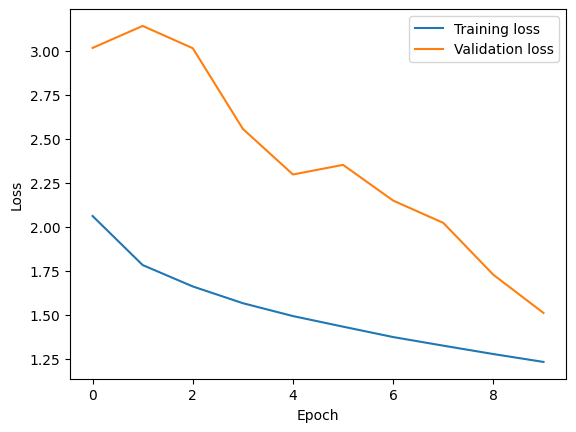

In [23]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [24]:
neural_net.eval()
all_predictions, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = neural_net(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

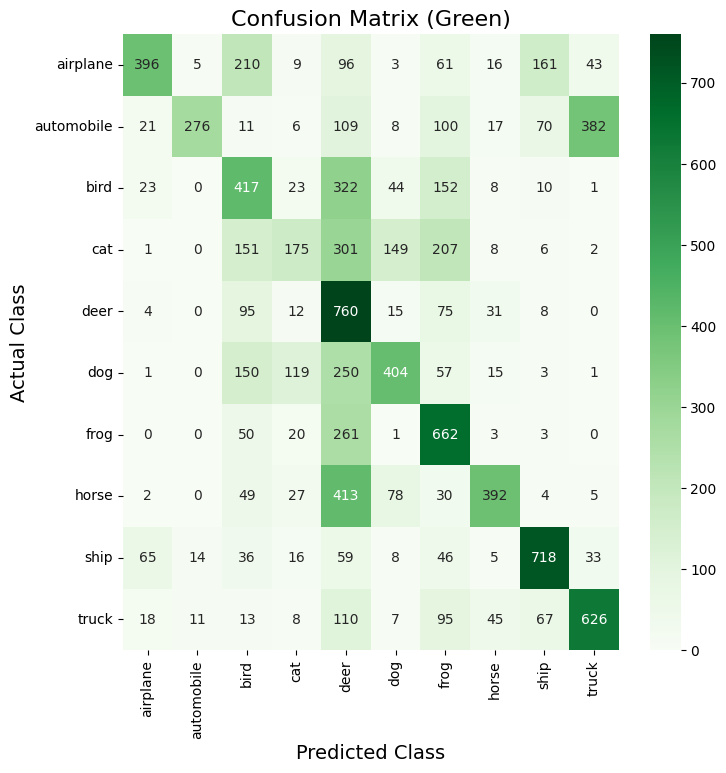

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Define the colormap as green
cmap = sns.color_palette("Greens", as_cmap=True)

# Create the heatmap with the specified colormap
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap=cmap, fmt="d", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("Actual Class", fontsize=14)
plt.title("Confusion Matrix (Green)", fontsize=16)
plt.show()

In [30]:
print(f'Total number of parameters in the model: {sum(p.numel() for p in neural_net.parameters())}')

Total number of parameters in the model: 11173962
